In [ ]:
# import numpy as np, pandas as pd
# import sqlite3 as sql
# import os
# import seaborn as sns
# import plotly.graph_objs as go
from dotenv import load_dotenv
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import db_info, db_table_samples, query_from_string, get_from_table, get_list_of_tables

In [ ]:
load_dotenv()

True

In [ ]:
get_list_of_tables()

FILM_YEAR :
   FILM_ID  FILM_YEAR FILM_DECADE
0  f_000kO       2010       2010s
1  f_021fk       2008       2000s
2  f_029HQ       1996       1990s
3  f_0uPqS       2018       2010s
4  f_01eag       1978       1970s
5  f_01C76       2006       2000s
6  f_020IU       2010       2010s
7  f_01ZfW       1988       1980s
8  f_02nwM       2014       2010s
9  f_0gH0O       2019       2010s
FILM_LETTERBOXD_STATS :
   FILM_ID  FILM_WATCH_COUNT  FILM_FAN_COUNT  FILM_LIKES_COUNT  \
0  f_000kO              5456               8               746   
1  f_021fk             63364              63              5070   
2  f_029HQ            293354             752             66864   
3  f_0uPqS              4591              95              1879   
4  f_01eag             16531              29              3783   
5  f_01C76             30589               6              2399   
6  f_020IU             52275              23              4825   
7  f_01ZfW             79674             201             18588

In [12]:
return_top_streaming_watchlist = """

SELECT a.FILM_ID, b.FILM_TITLE, e.FILM_YEAR, a.FILM_WATCH_COUNT, a.FILM_RATING, CASE WHEN d.FILM_ID IS NULL THEN 0 ELSE 1 END AS STREAMING

FROM FILM_LETTERBOXD_STATS a

LEFT JOIN FILM_TITLE b
ON a.FILM_ID = b.FILM_ID

LEFT JOIN WATCHED c
ON a.FILM_ID = c.FILM_ID

LEFT JOIN FILMS_AVAILABLE_TO_STREAM d
ON a.FILM_ID = d.FILM_ID

LEFT JOIN FILM_YEAR e
ON a.FILM_ID = e.FILM_ID

LEFT JOIN FILM_GENRE f
ON a.FILM_ID = f.FILM_ID

WHERE a.FILM_RATING IS NOT NULL
AND c.FILM_ID IS NULL
AND d.FILM_ID IS NOT NULL
AND f.FILM_GENRE = 'horror'

ORDER BY a.FILM_WATCH_COUNT DESC

"""

In [13]:
streaming_horrors = query_from_string(return_top_streaming_watchlist)
streaming_horrors

,FILM_ID,FILM_TITLE,FILM_YEAR,FILM_WATCH_COUNT,FILM_RATING,STREAMING
0,f_0lLBE,Fear Street: 1666,2021,253377,3.45,1
1,f_03dqc,Insidious: Chapter 2,2013,194757,3.03,1
2,f_0b5EG,Ouija: Origin of Evil,2016,113482,2.90,1
3,f_02Y1c,V/H/S,2012,108583,2.87,1
4,f_02aMM,King Kong,1933,107273,3.84,1
...,...,...,...,...,...,...
278,f_0ita0,The Village in the Woods,2019,428,2.35,1
279,f_01n6W,Moon in Scorpio,1987,351,2.19,1
280,f_03HUm,Twisted,1986,330,2.53,1
281,f_0fq64,The Ninth Passenger,2018,313,1.68,1


In [14]:
streaming_horrors.sort_values('FILM_RATING', ascending=False)

,FILM_ID,FILM_TITLE,FILM_YEAR,FILM_WATCH_COUNT,FILM_RATING,STREAMING
4,f_02aMM,King Kong,1933,107273,3.84,1
88,f_0jDZk,Tumbbad,2018,16472,3.81,1
57,f_01tJ6,Martin,1976,24403,3.79,1
109,f_01blq,Lucifer Rising,1974,12757,3.77,1
33,f_01qme,Blood and Black Lace,1964,37192,3.74,1
...,...,...,...,...,...,...
26,f_02a4U,Jaws: The Revenge,1987,46106,1.53,1
108,f_0CKk2,Grimcutty,2022,12763,1.53,1
67,f_00s3Q,Jeepers Creepers 3,2017,22469,1.50,1
250,f_015So,Howling: New Moon Rising,1995,1683,1.36,1


<Axes: xlabel='FILM_YEAR', ylabel='FILM_RATING'>

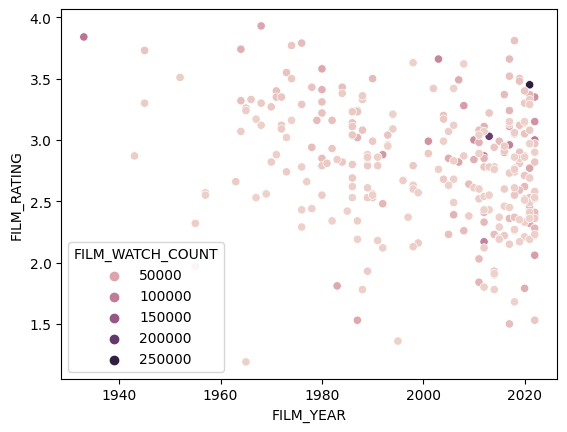

In [7]:
sns.scatterplot(x=streaming_horrors['FILM_YEAR'], y=streaming_horrors['FILM_RATING'], hue=streaming_horrors['FILM_WATCH_COUNT'])

In [8]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=streaming_horrors['FILM_YEAR'],
        y=streaming_horrors['FILM_RATING'],
        mode='markers',
        marker=dict(
            size=50*streaming_horrors['FILM_WATCH_COUNT']/streaming_horrors['FILM_WATCH_COUNT'].max(),
            color=streaming_horrors['FILM_WATCH_COUNT'],
            line=dict(width=1, color='white')
        ),
        text=streaming_horrors['FILM_TITLE'],
        hovertemplate=
            '<b>%{text}</b><br>' +
            'Year: %{x}<br>' +
            'Rating: %{y}<br>' +
            'Watch Count: %{marker.color}<br>'
    )
)
fig.show()

In [28]:
from justwatch import JustWatch
just_watch = JustWatch(country='GB')
film_id = 'f_0aXA2'
film_url_title = get_from_table('FILM_TITLE', film_id, 'FILM_URL_TITLE')
film_release_year = get_from_table('FILM_YEAR', film_id, 'FILM_YEAR')
results = just_watch.search_for_item(query=film_url_title, release_year_from=film_release_year-1, release_year_until=film_release_year+1)
first_result = results['items'][0]
provider_abbreviations = list(set([x['package_short_name'] for x in first_result['offers'] if x['monetization_type'] in ['flatrate', 'free', 'ads']]))

'Possibly in Michigan'

In [37]:
[x.get('title') for x in results['items']]

['Once Upon a Time in America',
 'The Wind in the Willows',
 'The Jewel in the Crown',
 'Missing in Action',
 'Charles in Charge',
 'The Best Little Whorehouse in Texas',
 "Smiley's People",
 'Miss Marple: The Body in the Library',
 'Made in Britain',
 'Amadeus',
 'The Woman in Red',
 "Dead Men Don't Wear Plaid",
 'Falling in Love',
 'I Ought to Be in Pictures',
 "Agatha Christie's Partners in Crime",
 'A Blade in the Dark']

In [ ]:
"""SELECT * FROM """